# Classifying Songs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy
import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv('data.csv', index_col=0)
print(df.head())
print(df.shape)
#print(df.info())

   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062             4.0    0.286   
1    0.1370   -10.401     1       0.0794  160.083             4.0    0.588   
2    0.1590    -7.148     1       0.2890   75.044             4.0    0.173   
3    0.0922   -15.236     1       0.0261   86.468             4.0    0.230   
4    0.4390   -11.648     0       0.0694  174.004             4.0    0.904   

   target      song_title            artist  
0       1        Mask 

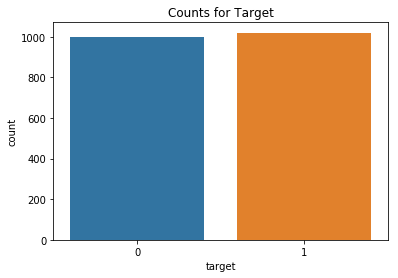

1    1020
0     997
Name: target, dtype: int64


In [4]:
sns.countplot(df.target)
plt.title('Counts for Target')
plt.show()

print(df.target.value_counts())

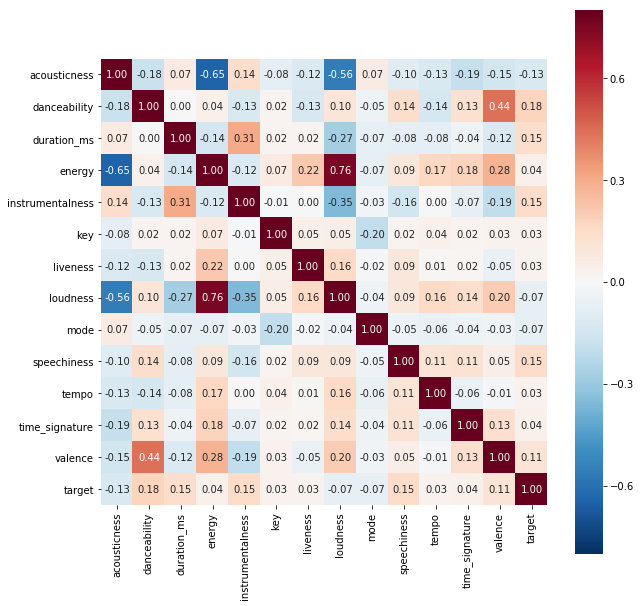

In [5]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-0.8, vmax=0.8, annot=True, fmt='0.2f', square=True, cmap='RdBu_r')
plt.show()

Only correlation is between (energy, loudness) = 0.76, (energy, acousticness) = -0.65, (loudness, acousticness) = -0.56.

	Energy: a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    
    Acousticness: a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    
    Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db

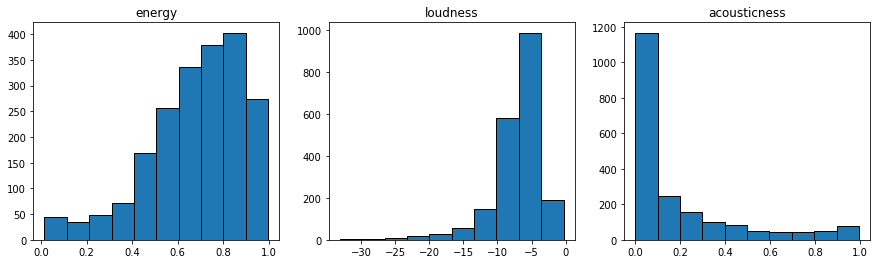

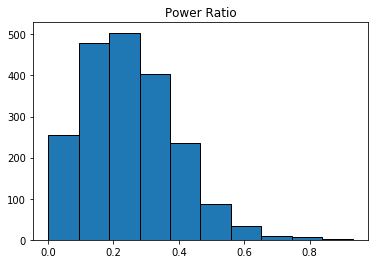

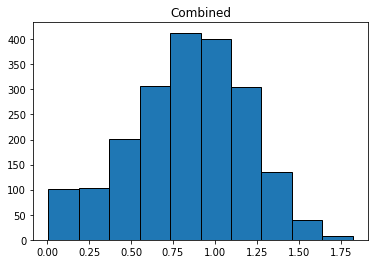

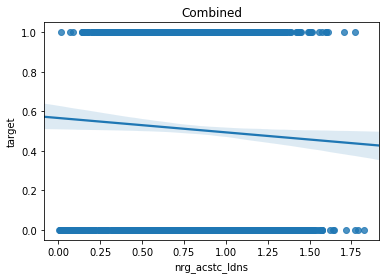

In [6]:
# Distributions for highly correlated variables
fig, ax = plt.subplots(1, 3, figsize=(15,4))

for i,x in enumerate(['energy', 'loudness', 'acousticness']):
    ax[i].hist(df[x], edgecolor='k')
    ax[i].set_title(str(x))

plt.show()

# loudness is in decibels which is dB = 10 log(power output/power input)
# convert to power ratio (Pout/Pin)
df['power_ratio'] = 10**(df.loudness/10)
plt.hist(df['power_ratio'],edgecolor='k')
plt.title('Power Ratio')
plt.show()


#create new variable 
# the louder the song the more energy - both inversely related to acousticness
df['nrg_acstc_ldns'] = ((df.energy+df.power_ratio)/(df.acousticness+1))
df['nrg_acstc_ldns'] = df['nrg_acstc_ldns'].astype('float')

plt.hist(df['nrg_acstc_ldns'],edgecolor='k')
plt.title('Combined')
plt.show()

sns.regplot(df['nrg_acstc_ldns'], df.target)
plt.title('Combined')
plt.show()

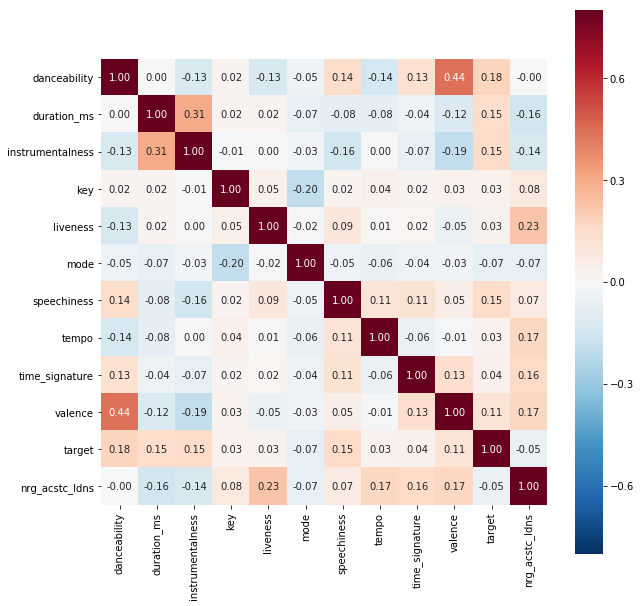

In [7]:
df = df.drop(['loudness', 'energy', 'acousticness', 'power_ratio'],1)
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-0.8, vmax=0.8, annot=True, fmt='0.2f', square=True, cmap='RdBu_r')
plt.show()

In [119]:
# try a baseline fit of the neural network

# get dummies
df_dum = pd.get_dummies(df)

# split data
X = df_dum.drop('target', 1)
y = df_dum.target

#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2) - maybe we will use this 
# but for now we will just cross validate

def mlp(X,y):
    
    # time it
    t0 =time.time()

    # initialize MLP
    mlp = MLPClassifier(hidden_layer_sizes=(50, 100, ), 
                        activation='relu',    # identity, logistic, tanh, relu
                        solver='adam',           # lbfgs, sgd, adam 
                        alpha=1e-5,               # L2 penalty (regularization term) parameter
                        batch_size='auto',        # used for stochastic optimizers
                        learning_rate='constant', # constant, invscaling, adaptive - only used for sgd
                        learning_rate_init=0.001, # only used for sgd or adam
                        power_t=0.5,              # only used for sgd or adam
                        max_iter=200,             # number of iterations or until tol is reached
                        shuffle=True,             # only used for sgd or adam
                        random_state=42, 
                        tol=0.0001, 
                        verbose=False, 
                        warm_start=False, 
                        momentum=0.9,            # only sdg
                        nesterovs_momentum=True, # only sgd 
                        early_stopping=False, 
                        validation_fraction=0.1, 
                        beta_1=0.9,              # only adam
                        beta_2=0.999,            # only adam
                        epsilon=1e-08,           # only adam
                        n_iter_no_change=10)
    # fit
    fit = mlp.fit(X, y)

    # score
    score_mlp = mlp.score(X,y)
    print('Baseline score MLP: {}'.format(score_mlp))
    print('')
    t1 = time.time()

    print('Time for scoring baseline neural net: {0:0.5f}s'.format(t1-t0))
    print('-'*50)

    # time cross validation
    t0=time.time()
    cvs_mlp = cross_val_score(mlp, X, y, cv=5)
    print('Cross Validation for MLP:')
    print(cvs_mlp)
    print('')
    t1=time.time()
    print('Time for cross validation for baseline neural net: {0:0.5f}s'.format(t1-t0))


    # confusion matrix and classification report
    pred_mlp = mlp.predict(X)
    print(pred_mlp)
    print('Confusion Matrix for MLP:')
    print(confusion_matrix(y, pred_mlp))

    print('Classification Report:')
    print(classification_report(y, pred_mlp))
    
    return fit

In [124]:
# baseline for Random Forest
def rfc(X,y, md=3, mid=0.02):
    
    # Time start
    t0 = time.time()
    rfc = RandomForestClassifier(n_estimators=1000, 
                                 criterion='entropy', 
                                 max_depth=md, 
                                 min_samples_split=2, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features='sqrt', 
                                 max_leaf_nodes=None, 
                                 min_impurity_decrease=mid, # prunes tree when impurity is less than value
                                 min_impurity_split=None, 
                                 bootstrap=True, 
                                 oob_score=False, 
                                 n_jobs=None, 
                                 random_state=42, 
                                 verbose=0, 
                                 warm_start=False, 
                                 class_weight=None)

    # fit
    fit = rfc.fit(X, y)

    # score
    score_rfc = rfc.score(X,y)
    print('Baseline score RFC: {}'.format(score_rfc))
    print('')
    t1 = time.time()

    print('Time for scoring baseline Random Forest: {0:0.5f}s'.format(t1-t0))
    print('-'*50)

    # time cross validation
    t0=time.time()
    cvs_rfc = cross_val_score(rfc, X, y, cv=5)
    print("Cross Validiation for RFC:")
    print(cvs_rfc)
    print('')
    t1=time.time()
    print('Time for cross validation for baseline Random Forest: {0:0.5f}s'.format(t1-t0))

    # confusion matrix and classification report
    pred_rfc = rfc.predict(X)
    print('Confusion Matrix for RFC:')
    print(confusion_matrix(y, pred_rfc))

    print('Classification Report:')
    print(classification_report(y, pred_rfc))
    
    return fit

In [10]:
# baseline for Gradient Boosting

def gbc(X,y):
    
    # Time start
    t0 = time.time()
    gbc = GradientBoostingClassifier(loss='exponential', 
                               learning_rate=0.001, 
                               n_estimators=100, 
                               subsample=.8, 
                               criterion='friedman_mse', 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, 
                               max_depth=3, 
                               min_impurity_decrease=0.0, 
                               min_impurity_split=None, 
                               init=None, 
                               random_state=42, 
                               max_features='sqrt', 
                               verbose=0, 
                               max_leaf_nodes=None, 
                               warm_start=False, 
                               presort='auto', 
                               validation_fraction=0.1, 
                               n_iter_no_change=None, 
                               tol=0.0001)

    # fit
    fit = gbc.fit(X, y)

    # score
    score_gbc = gbc.score(X,y)
    print('Baseline score: {}'.format(score_gbc))
    print('')
    t1 = time.time()

    print('Time for scoring baseline Gradient Boosting Classifier: {0:0.5f}s'.format(t1-t0))
    print('-'*50)

    # time cross validation
    t0=time.time()
    cvs_gbc = cross_val_score(gbc, X, y, cv=5)
    print('Cross Validation for GBC')
    print(cvs_gbc)
    print('')
    t1=time.time()
    print('Time for cross validation for baseline Gradient Boosting Classifier: {0:0.5f}s'.format(t1-t0))


    # confusion matrix and classification report
    pred_gbc = gbc.predict(X)
    print('Confusion Matrix for GBC:')
    print(confusion_matrix(y, pred_gbc))

    print('Classification Report:')
    print(classification_report(y, pred_gbc))
    return fit

In [120]:
mlp(X,y)

Baseline score MLP: 0.5057015369360436

Time for scoring baseline neural net: 2.95114s
--------------------------------------------------
Cross Validation for MLP:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline neural net: 14.84365s
[1 1 1 ... 1 1 1]
Confusion Matrix for MLP:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017



MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [123]:
rfc(X,y, md=3, mid=0.02)

Baseline score RFC: 0.5979176995537928

Time for scoring baseline Random Forest: 1.27680s
--------------------------------------------------
Cross Validiation for RFC:
[0.56188119 0.56435644 0.54342432 0.5955335  0.55831266]

Time for cross validation for baseline Random Forest: 5.40452s
Confusion Matrix for RFC:
[[226 771]
 [ 40 980]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.23      0.36       997
           1       0.56      0.96      0.71      1020

   micro avg       0.60      0.60      0.60      2017
   macro avg       0.70      0.59      0.53      2017
weighted avg       0.70      0.60      0.53      2017



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.02, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [13]:
print(gbc(X,y))

Baseline score: 0.5061973227565691

Time for scoring baseline Gradient Boosting Classifier: 0.46215s
--------------------------------------------------
Cross Validation for GBC
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline Gradient Boosting Classifier: 1.62450s
Confusion Matrix for GBC:
[[   1  996]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.75      0.50      0.34      2017
weighted avg       0.75      0.51      0.34      2017

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf

It appears that I am classifying everything in the Neural Net and Random Forest classifiers as a 'GOOD' songs. The Gradient Booster at least got 4 songs correctly identified as bad.  

Solutions we will try:

- Training the models on only one class to see if it can predict that class
- Preprocessing (normalizing the data)
- Split data 50-50 so not training only all goods and bads
- Clustering
- PCA

## Train models on only one class

In [14]:
# get only bads
only_bad = df[df.target==0]

# get new dummies
only_bad = pd.get_dummies(only_bad)

# split
X_only_bad = only_bad.drop('target', 1)
y_only_bad = only_bad.target


# get only goods
only_good = df[df.target==1]

# get new dummies
only_good = pd.get_dummies(only_good)

# split
X_only_good = only_good.drop('target', 1)
y_only_good = only_good.target

In [15]:
# neural net with only bad
bad = mlp(X_only_bad, y_only_bad)
good = mlp(X_only_good, y_only_good)

Baseline score MLP: 1.0

Time for scoring baseline neural net: 0.37526s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 1.70043s
Confusion Matrix for MLP:
[[997]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997

   micro avg       1.00      1.00      1.00       997
   macro avg       1.00      1.00      1.00       997
weighted avg       1.00      1.00      1.00       997

Baseline score MLP: 1.0

Time for scoring baseline neural net: 0.38694s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 1.67649s
Confusion Matrix for MLP:
[[1020]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1020

   micro avg       1.00      1.00      1.00     

In [16]:
# try on full data
print(bad.score(X, y))
print(confusion_matrix(y, bad.predict(X)))

print(good.score(X, y))
print(confusion_matrix(y, good.predict(X)))

0.49429846306395636
[[ 997    0]
 [1020    0]]
0.5057015369360436
[[   0  997]
 [   0 1020]]


In [17]:
# Random Forest with only bad
bad1 = rfc(X_only_bad, y_only_bad)
good1 = rfc(X_only_good, y_only_good)

Baseline score RFC: 1.0

Time for scoring baseline Random Forest: 0.58147s
--------------------------------------------------
Cross Validiation for RFC:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Random Forest: 2.78053s
Confusion Matrix for RFC:
[[997]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997

   micro avg       1.00      1.00      1.00       997
   macro avg       1.00      1.00      1.00       997
weighted avg       1.00      1.00      1.00       997

Baseline score RFC: 1.0

Time for scoring baseline Random Forest: 0.60448s
--------------------------------------------------
Cross Validiation for RFC:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Random Forest: 3.28844s
Confusion Matrix for RFC:
[[1020]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1020

   micro avg       1.00      1.00 

In [18]:
# try on full data
print(bad1.score(X, y))
print(confusion_matrix(y, bad1.predict(X)))

print(good1.score(X, y))
print(confusion_matrix(y, good1.predict(X)))

0.49429846306395636
[[ 997    0]
 [1020    0]]
0.5057015369360436
[[   0  997]
 [   0 1020]]


Gradient boosting requires two classes.

## Preprocessing

In [19]:
# normalize data
X_norm = normalize(df_dum.drop('target',1))

In [20]:
mlp(X_norm, y)

Baseline score MLP: 0.5057015369360436

Time for scoring baseline neural net: 0.34508s
--------------------------------------------------
Cross Validation for MLP:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline neural net: 2.25357s
Confusion Matrix for MLP:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017



MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [21]:
rfc(X_norm, y)

Baseline score RFC: 0.5057015369360436

Time for scoring baseline Random Forest: 1.18383s
--------------------------------------------------
Cross Validiation for RFC:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline Random Forest: 8.95052s
Confusion Matrix for RFC:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.2, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
gbc(X_norm, y)

Baseline score: 0.5057015369360436

Time for scoring baseline Gradient Boosting Classifier: 0.55751s
--------------------------------------------------
Cross Validation for GBC
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline Gradient Boosting Classifier: 3.60935s
Confusion Matrix for GBC:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## 50-50 Split

In [125]:
# 50-50 split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_norm, y, test_size=0.5)

In [126]:
for i, x in zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc]):
    i = x(Xtrain, ytrain)

Baseline score MLP: 0.498015873015873

Time for scoring baseline neural net: 1.43583s
--------------------------------------------------
Cross Validation for MLP:
[0.50246305 0.5        0.49751244 0.50248756 0.50248756]

Time for cross validation for baseline neural net: 6.69599s
[1 1 1 ... 1 1 1]
Confusion Matrix for MLP:
[[  0 506]
 [  0 502]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       506
           1       0.50      1.00      0.66       502

   micro avg       0.50      0.50      0.50      1008
   macro avg       0.25      0.50      0.33      1008
weighted avg       0.25      0.50      0.33      1008

Baseline score RFC: 0.501984126984127

Time for scoring baseline Random Forest: 1.13314s
--------------------------------------------------
Cross Validiation for RFC:
[0.56650246 0.5        0.53731343 0.53233831 0.50248756]

Time for cross validation for baseline Random Forest: 4.91979s
Confusion Matr

In [127]:
modmlp = mlp(Xtrain, ytrain)
modmlp.score(Xtest, ytest)

Baseline score MLP: 0.498015873015873

Time for scoring baseline neural net: 1.55346s
--------------------------------------------------
Cross Validation for MLP:
[0.50246305 0.5        0.49751244 0.50248756 0.50248756]

Time for cross validation for baseline neural net: 6.88653s
[1 1 1 ... 1 1 1]
Confusion Matrix for MLP:
[[  0 506]
 [  0 502]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       506
           1       0.50      1.00      0.66       502

   micro avg       0.50      0.50      0.50      1008
   macro avg       0.25      0.50      0.33      1008
weighted avg       0.25      0.50      0.33      1008



0.5133795837462835

## Clustering

In [26]:
# Find optimal cluster size for kmeans
arikm = []
for i in range(1,11):
    ykm = KMeans(n_clusters=i, random_state=42).fit_predict(X_norm)
    arikm.append(sklearn.metrics.adjusted_rand_score(y, ykm))
    
zippedkm = dict(zip(range(1,11),arikm))
valkm = list(zippedkm.values())
keykm= list(zippedkm.keys())
num_cluster_km = keykm[valkm.index(max(valkm))]

print('Number of clusters={}, ARI={} for KMeans'.format(num_cluster_km, max(valkm)))

Number of clusters=4, ARI=0.006086073232680693 for KMeans


In [27]:
# mean shift
bandwidth = estimate_bandwidth(X_norm, quantile=0.2)
yms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True).fit_predict(X_norm)
ari_ms = sklearn.metrics.adjusted_rand_score(y, yms)
num_clusters_ms = len(np.unique(yms))

print('Number of clusters={}, ARI={} for Mean Shift'.format(num_clusters_ms, ari_ms))

Number of clusters=10, ARI=-9.484723164325949e-05 for Mean Shift


In [28]:
# Spectral Clustering
arisc = []
for i in range(1,10):
    ysc = SpectralClustering(n_clusters=i, random_state=42).fit_predict(X_norm)
    arisc.append(sklearn.metrics.adjusted_rand_score(y, ysc))
    
zippedsc = dict(zip(range(1,10),arisc))
valsc = list(zippedsc.values())
keysc= list(zippedsc.keys())
num_cluster_sc = keysc[valsc.index(max(valsc))]

print('Number of clusters={}, ARI={} for Spectral Clustering'.format(num_cluster_sc, max(valsc)))

Number of clusters=8, ARI=0.010760447001250516 for Spectral Clustering


In [29]:
ysc = SpectralClustering(n_clusters=10, random_state=42).fit_predict(X_norm)
arisc=(sklearn.metrics.adjusted_rand_score(y, ysc))
print(arisc)

LinAlgError: the leading minor of order 12 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [30]:
# Affinity Propagation
yap = AffinityPropagation().fit_predict(X_norm)
ari_ap = sklearn.metrics.adjusted_rand_score(y, yap)
num_clusters_ap = len(np.unique(yap))

print('Number of clusters={}, ARI={} for Affinity Propagation'.format(num_clusters_ap, ari_ap))

Number of clusters=188, ARI=0.0008607426124199785 for Affinity Propagation


The spectral clustering scored the best with 8 clusters.  Let's try the models again with the spectral clusters added to the dataset.

In [32]:
sc = SpectralClustering(n_clusters=8, random_state=42).fit_predict(X_norm)
print(sc.shape)
#for i, x in zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc]):
    #i = x(Xsc, y)

(2017,)


In [129]:
cluster_df = pd.concat([df, pd.Series(sc).rename('labels')], 1)
cluster_df.drop('target',1, inplace=True)
cluster_df = pd.get_dummies(cluster_df)
print(cluster_df.shape)
for i, x in zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc]):
    i = x(cluster_df, y)

(2017, 3313)
Baseline score MLP: 0.5057015369360436

Time for scoring baseline neural net: 4.06360s
--------------------------------------------------
Cross Validation for MLP:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline neural net: 15.78842s
[1 1 1 ... 1 1 1]
Confusion Matrix for MLP:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017

Baseline score RFC: 0.5894893406048587

Time for scoring baseline Random Forest: 1.30021s
--------------------------------------------------
Cross Validiation for RFC:
[0.52970297 0.53465347 0.51364764 0.58064516 0.56823821]

Time for cross validation for baseline Random Forest: 5.5

In [50]:
# try without the songs and artist
no_song_artist = pd.concat([df.drop(['target','song_title','artist'], 1), pd.Series(sc).rename("labels")], 1)
for i, x in zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc]):
    i = x(no_song_artist, y)

Baseline score MLP: 0.5057015369360436

Time for scoring baseline neural net: 0.04785s
--------------------------------------------------
Cross Validation for MLP:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline neural net: 0.18581s
Confusion Matrix for MLP:
[[   0  997]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       997
           1       0.51      1.00      0.67      1020

   micro avg       0.51      0.51      0.51      2017
   macro avg       0.25      0.50      0.34      2017
weighted avg       0.26      0.51      0.34      2017

Baseline score RFC: 0.5057015369360436

Time for scoring baseline Random Forest: 1.04770s
--------------------------------------------------
Cross Validiation for RFC:
[0.5049505  0.5049505  0.50620347 0.50620347 0.50620347]

Time for cross validation for baseline Random Forest: 4.21973s
Confusion Matrix for RFC:


## Try some more feature engineering

I think at this point we need to make some changes to the data.  Since the target variable is given, let's try creating variables that are associated with bad songs to try to capture them.

In [75]:
# creating variables based on sentiment
sentiment_df = df.copy()
cols = sentiment_df.drop(['target'], 1)
# sentiment for songs
for x in cols.columns:
    sentiment_df['negative_'+str(x)] = sentiment_df[x][sentiment_df['target']==0]
    sentiment_df['positive_'+str(x)] = sentiment_df[x][sentiment_df['target']==1]

sentiment_df.fillna(0, inplace=True)
print(sentiment_df.head())

   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness        ...         negative_tempo  \
0    0.1650    -8.795     1       0.4310        ...                    0.0   
1    0.1370   -10.401     1       0.0794        ...                    0.0   
2    0.1590    -7.148     1       0.2890        ...                    0.0   
3    0.0922   -15.236     1       0.0261        ...                    0.0   
4    0.4390   -11.648     0       0.0694        ...                    0.0   

   positive_tempo  negative_time_signature  positive_time_signature 

In [76]:
sentiment_dfdum = pd.get_dummies(sentiment_df)
sent_X = sentiment_dfdum.drop('target', 1)
sent_y = sentiment_dfdum.target

In [83]:
for i, x in zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc]):
    i = x(sent_X, sent_y)

Baseline score MLP: 1.0

Time for scoring baseline neural net: 1.32862s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 5.59534s
Confusion Matrix for MLP:
[[ 997    0]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00      1020

   micro avg       1.00      1.00      1.00      2017
   macro avg       1.00      1.00      1.00      2017
weighted avg       1.00      1.00      1.00      2017

Baseline score RFC: 1.0

Time for scoring baseline Random Forest: 1.27852s
--------------------------------------------------
Cross Validiation for RFC:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Random Forest: 5.14716s
Confusion Matrix for RFC:
[[ 997    0]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

     

As expected we scored a lot better.  Let's create a training set containing 50 of the data to test the models.

In [84]:
# 50-50 split
Xtrain_sent, Xtest_sent, ytrain_sent, ytest_sent = train_test_split(sent_X, sent_y, test_size=0.5)

In [68]:
model_mlp = mlp(Xtrain_sent, ytrain_sent)
print('='*50)
# test
print('TEST RESULTS')

print('Test score: ',model_mlp.score(Xtest_sent, ytest_sent))
print(confusion_matrix(ytest_sent, model_mlp.predict(Xtest_sent)))
print(classification_report(ytest_sent, model_mlp.predict(Xtest_sent)))

Baseline score MLP: 1.0

Time for scoring baseline neural net: 0.88999s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 3.95516s
Confusion Matrix for MLP:
[[498   0]
 [  0 510]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008

TEST RESULTS
Test score:  1.0
[[499   0]
 [  0 510]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1009
   macro avg       1.00      1.00      1.00      1009
weighted avg       1.00      1.00      1.00      

In [69]:
model_rfc = rfc(Xtrain_sent, ytrain_sent)
print('='*50)
# test
print('TEST RESULTS')

print('Test score: ',model_rfc.score(Xtest_sent, ytest_sent))
print(confusion_matrix(ytest_sent, model_rfc.predict(Xtest_sent)))
print(classification_report(ytest_sent, model_rfc.predict(Xtest_sent)))

Baseline score RFC: 1.0

Time for scoring baseline Random Forest: 1.06485s
--------------------------------------------------
Cross Validiation for RFC:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Random Forest: 3.90829s
Confusion Matrix for RFC:
[[498   0]
 [  0 510]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008

TEST RESULTS
Test score:  1.0
[[499   0]
 [  0 510]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1009
   macro avg       1.00      1.00      1.00      1009
weighted avg       1.00      1.00      1.0

In [70]:
model_gbc = gbc(Xtrain_sent, ytrain_sent)
print('='*50)
# test
print('TEST RESULTS')

print('Test score: ',model_gbc.score(Xtest_sent, ytest_sent))
print(confusion_matrix(ytest_sent, model_gbc.predict(Xtest_sent)))
print(classification_report(ytest_sent, model_gbc.predict(Xtest_sent)))

Baseline score: 1.0

Time for scoring baseline Gradient Boosting Classifier: 0.37489s
--------------------------------------------------
Cross Validation for GBC
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Gradient Boosting Classifier: 1.41078s
Confusion Matrix for GBC:
[[498   0]
 [  0 510]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008

TEST RESULTS
Test score:  1.0
[[499   0]
 [  0 510]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      1009
   macro avg       1.00      1.00      1.00      1009
weighted avg      

Try without the artist and song in the sentiment analysis.

In [94]:
no_song_artist_sent = df.copy()
cols = no_song_artist_sent.drop(['target', 'song_title', 'artist'], 1)
# sentiment for songs
for x in cols.columns:
    no_song_artist_sent['negative_'+str(x)] = no_song_artist_sent[x][no_song_artist_sent['target']==0]
    no_song_artist_sent['positive_'+str(x)] = no_song_artist_sent[x][no_song_artist_sent['target']==1]

no_song_artist_sent.fillna(0, inplace=True)
no_song_artist_sent.drop(['song_title', 'artist'], 1, inplace=True)
print(no_song_artist_sent.head())

   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness        ...         negative_mode  \
0    0.1650    -8.795     1       0.4310        ...                   0.0   
1    0.1370   -10.401     1       0.0794        ...                   0.0   
2    0.1590    -7.148     1       0.2890        ...                   0.0   
3    0.0922   -15.236     1       0.0261        ...                   0.0   
4    0.4390   -11.648     0       0.0694        ...                   0.0   

   positive_mode  negative_speechiness  positive_speechiness  negative_tem

In [101]:
for i, x in list(zip(['modmlp', 'modrfc', 'modgbc'],[mlp, rfc, gbc])):
    i = x(no_song_artist_sent, y)

Baseline score MLP: 1.0

Time for scoring baseline neural net: 0.10252s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 0.37596s
Confusion Matrix for MLP:
[[ 997    0]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00      1020

   micro avg       1.00      1.00      1.00      2017
   macro avg       1.00      1.00      1.00      2017
weighted avg       1.00      1.00      1.00      2017

Baseline score RFC: 1.0

Time for scoring baseline Random Forest: 1.17266s
--------------------------------------------------
Cross Validiation for RFC:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline Random Forest: 5.00219s
Confusion Matrix for RFC:
[[ 997    0]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

     

In [112]:
xx = pd.get_dummies(df.drop('target',1))
print(xx.shape)

print(no_song_artist_sent.shape)
testdf = no_song_artist_sent.copy()
for i in range(3272):
    testdf[i] = 0
print(testdf.shape)

(2017, 3312)
(2017, 40)
(2017, 3312)


In [114]:
testmlp = mlp(testdf, y)

Baseline score MLP: 1.0

Time for scoring baseline neural net: 0.76022s
--------------------------------------------------
Cross Validation for MLP:
[1. 1. 1. 1. 1.]

Time for cross validation for baseline neural net: 3.21329s
Confusion Matrix for MLP:
[[ 997    0]
 [   0 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00      1020

   micro avg       1.00      1.00      1.00      2017
   macro avg       1.00      1.00      1.00      2017
weighted avg       1.00      1.00      1.00      2017



In [116]:
testmlp.score(xx, y)

0.5057015369360436